In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [13]:
path ='../../../Data_preprocessing//RNA post_autoencoder+Clinic joined/Clinical_data_and_RNA_15_Features_PFS.csv'
data = pd.read_csv(path)
data.head(5)

,Unnamed: 0,RNA_ID,Age,Sarc,Rhab,Number_of_Prior_Therapies,Days_from_TumorSample_Collection_and_Start_of_Trial_Therapy,Tumor_Shrinkage,PFS,TM_TC_Ratio,...,IL25,LANCL1-AS1,LEMD1,PCMT1,RP11-120J4.1,RP11-374M1.2,SDR42E1,TARBP2,TRIM43B,VN2R17P
0,0,G138701_RCCBMS-00097-T_v1_RNA_OnPrem,62.0,0.0,0.0,2.0,707.0,0.0,5.490411,1.374775,...,0.693666,0.817111,0.678721,0.936250,0.663654,0.786407,1.000000,0.912529,0.587310,0.863040
1,1,G138701_RCCBMS-00099-T_v1_RNA_OnPrem,62.0,0.0,0.0,3.0,707.0,0.0,1.249315,1.374775,...,0.693666,0.817111,0.926248,0.958908,0.663654,0.786407,0.694015,0.903036,0.587310,0.863040
2,2,G138701_RCCBMS-00163-T_v1_RNA_OnPrem,62.0,0.0,0.0,2.0,707.0,0.0,5.654795,1.374775,...,0.693666,0.817111,0.880799,0.922139,0.663654,0.786407,0.869025,0.898032,0.587310,0.863040
3,3,G138701_RCCBMS-00116-T_v1_RNA_OnPrem,62.0,0.0,0.0,2.0,707.0,0.0,1.216438,1.374775,...,0.686828,0.794290,0.894078,0.921230,0.650857,0.772962,0.931136,0.873870,0.564337,0.855268
4,4,G138701_RCCBMS-00136-T_v1_RNA_OnPrem,62.0,0.0,0.0,2.0,707.0,0.0,2.860274,1.374775,...,0.689921,0.983649,0.802636,0.929383,0.793946,0.776255,0.902087,0.896762,0.552830,0.857563


In [14]:
X = data[['DLGAP4', 'EIF4A1P9', 'FAM172BP', 'GJA9', 'GPR155', 'IL25', 'LANCL1-AS1', 'LEMD1', 'PCMT1', 'RP11-120J4.1', 'RP11-374M1.2', 'SDR42E1', 'TARBP2', 'TRIM43B', 'VN2R17P']] #Seleccionamos todas las columnas quitando la columna Unnamed (id de la fila ) y la columna Target.
Y = []

for i in range (len(data)):
    if data.PFS[i]<3: # If PFS is lower than 3 months, I will consider it as NonResponder (NR)
        Y.append(0)
    else:
        Y.append(1)# If PFS is over 3 months, I will consider it as Responder (R)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=125)

print('Training set size:', len(X_train))
print('Target column size of the training set:', len(y_train))
print('Test set size:', len(X_test))
print('Target column size of the test set:', len(y_test))

Training set size: 115
Target column size of the training set: 115
Test set size: 29
Target column size of the test set: 29


In [16]:
param_grid = {'C': [1,2,5,7,10],
            'solver': ['newton-cg','liblinear'], 
            'max_iter':[25,50,100,200,500,1000],
            'random_state':[125]}

# I created a GridSearchCV which allows us to systematically evaluate and select the parameters of our model.
# By indicating a model and the parameters to test, you can evaluate the performance of the first one based on the
# seconds through cross validation.
clf = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
clf.fit(X_train , y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1, 2, 5, 7, 10],
                         'max_iter': [25, 50, 100, 200, 500, 1000],
                         'random_state': [125],
                         'solver': ['newton-cg', 'liblinear']})

In [17]:
print("Best estimate of parameters according to GridSearchCV:")
model = clf.best_estimator_
# Fit the model with the best parameters
model.fit(X_train , y_train)

Best estimate of parameters according to GridSearchCV:


LogisticRegression(C=1, max_iter=25, random_state=125, solver='newton-cg')

In [18]:
print("Best result of the cross validation of the model with the best paramters:" +str(clf.best_score_))

Best result of the cross validation of the model with the best paramters:0.5739130434782608


In [19]:
import shap
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
import ssl

In [20]:
explainer = shap.KernelExplainer(model.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)

Using 115 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 29/29 [00:19<00:00,  1.45it/s]


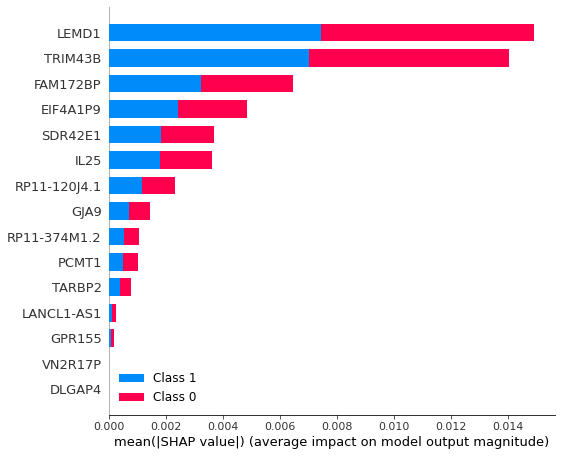

In [23]:
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = X_test.columns)
#shap_values[0] = NR, shap_values[1]=SR, shap_values[2]=R

In [25]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0][0], features = X_test.columns)

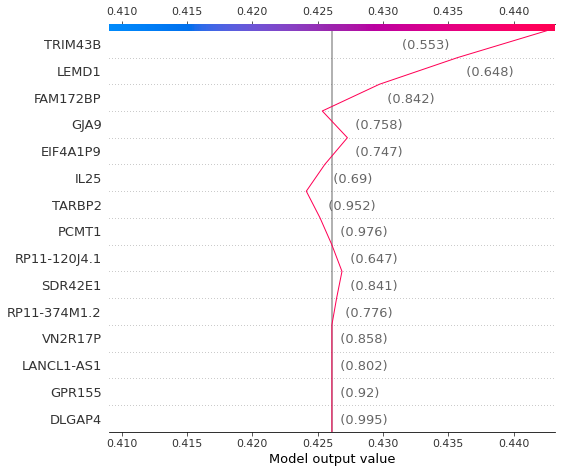

In [26]:
shap.decision_plot(explainer.expected_value[1], shap_values[0][0], features = X_test, feature_names = X_test.columns.tolist())

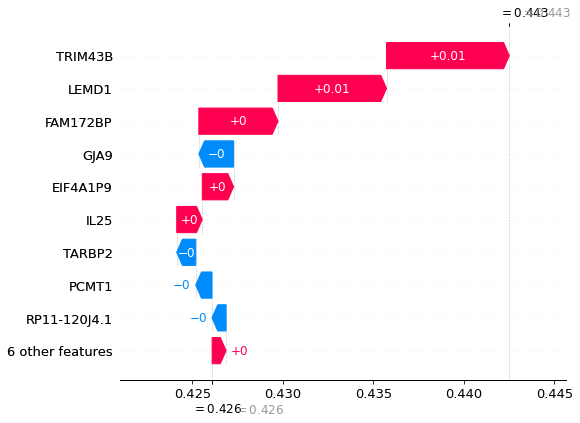

In [27]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[0][0], feature_names = X_test.columns)

In [28]:
shap.force_plot(explainer.expected_value[1], shap_values[0], X_test)